In [27]:
import pandas as pd
import glob
import os
# import keras.applications.efficientnet as efc
from tensorflow.python.keras.applications.efficientnet import *
import zipfile
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split
import numpy as np
import shutil
from tqdm import tqdm
print(tf.__version__)

2.3.0


In [26]:
# conda install matplotlib

Solving environment: ...working... done


Note: you may need to restart the kernel to use updated packages.# All requested packages already installed.




In [1]:
# conda install tensorflow==2.3.0

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\gto_n\anaconda3\envs\mushrooms_family_classification

  added / updated specs:
    - tensorflow==2.3.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    absl-py-0.15.0             |     pyhd3eb1b0_0         103 KB
    aiohttp-3.8.1              |   py37h2bbff1b_1         492 KB
    aiosignal-1.2.0            |     pyhd3eb1b0_0          12 KB
    astor-0.8.1                |   py37haa95532_0          47 KB
    astunparse-1.6.3           |             py_0          17 KB
    async-timeout-4.0.1        |     pyhd3eb1b0_0          10 KB
    asynctest-0.13.0           |             py_0          26 KB
    blinker-1.4                |   py37haa95532_0          23 KB
    brotlipy-0.7.0             |py37h2

In [31]:
# conda search cudnn

In [32]:
# conda install cudnn=7.6.5=cuda10.1_0

In [2]:
# check if tensorflow see the GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
# check name of GPU
!nvidia-smi

Mon Jun  6 12:49:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.95       Driver Version: 512.95       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   47C    P2    33W /  N/A |   1002MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
#читаем датасет
df = pd.read_csv('MO MI images - imagesAndNames.csv')
df

,image,name,created,license,rightsHolder
0,https://mushroomobserver.org/images/640/2.jpg,Xylaria magnoliae,2004-07-17,http://creativecommons.org/licenses/by-sa/3.0/,Nathan Wilson
1,https://mushroomobserver.org/images/640/16.jpg,Volvopluteus gloiocephalus,2005-01-07,http://creativecommons.org/licenses/by-sa/3.0/,Nathan Wilson
2,https://mushroomobserver.org/images/640/26.jpg,Panellus stipticus,2004-11-26,http://creativecommons.org/licenses/by-sa/3.0/,Nathan Wilson
3,https://mushroomobserver.org/images/640/36.jpg,Sutorius eximius,2004-07-14,http://creativecommons.org/licenses/by-sa/3.0/,Nathan Wilson
4,https://mushroomobserver.org/images/640/37.jpg,Harrya chromapes,1994-09-15,http://creativecommons.org/licenses/by-sa/3.0/,Nathan Wilson
...,...,...,...,...,...
254917,https://mushroomobserver.org/images/640/131437...,Laricifomes officinalis,2021-03-10,http://creativecommons.org/licenses/by-sa/3.0/,-Josh
254918,https://mushroomobserver.org/images/640/131437...,Laricifomes officinalis,2021-03-10,http://creativecommons.org/licenses/by-sa/3.0/,-Josh
254919,https://mushroomobserver.org/images/640/131437...,Laricifomes officinalis,2021-03-10,http://creativecommons.org/licenses/by-sa/3.0/,-Josh
254920,NaN,NaN,NaN,NaN,NaN


In [5]:
# Получаем список фото, которые у нас имеются на данный момент
jpgFilenamesList = glob.glob('./data/*.jpg')
photos = []
for i in jpgFilenamesList:
    photos.append(int((os.path.basename(i))[:-4]))

In [6]:
# Перекраиваем датасет под имеющиеся у нас фото
df_exist_photos = df[df.index.isin(photos)]

In [7]:
# Составим топ-1000 семейств в имеющимся у нас датасете
families = df_exist_photos['name'].str.split(n=1).str[0].value_counts()[:1000]
families

Psilocybe              8230
Amanita                6843
Russula                6101
Cortinarius            4161
Mycena                 3223
                       ... 
Comatricha                7
Lignoscripta              7
Cyclaneusma               7
Lobothallia               7
Nothophaeocryptopus       7
Name: name, Length: 1000, dtype: int64

In [8]:
# Рассмотрим сколько фотографий топ-1000 семейств имеется
families.sum()

148538

In [9]:
# Составим датасет, состоящий только из топ-100 грибных семейств
top_1000 = df_exist_photos[df_exist_photos.name.isin(families.index)]
top_1000

,image,name,created,license,rightsHolder
16,https://mushroomobserver.org/images/640/88.jpg,Strobilomyces,2004-07-21,http://creativecommons.org/licenses/by-sa/3.0/,Nathan Wilson
17,https://mushroomobserver.org/images/640/90.jpg,Strobilomyces,1994-09-15,http://creativecommons.org/licenses/by-sa/3.0/,Nathan Wilson
29,https://mushroomobserver.org/images/640/159.jpg,Coprinopsis,1994-02-15,http://creativecommons.org/licenses/by-sa/3.0/,Nathan Wilson
60,https://mushroomobserver.org/images/640/394.jpg,Helvella,2005-01-07,http://creativecommons.org/licenses/by-sa/3.0/,Nathan Wilson
62,https://mushroomobserver.org/images/640/396.jpg,Helvella,2005-02-05,http://creativecommons.org/licenses/by-sa/3.0/,Nathan Wilson
...,...,...,...,...,...
249740,https://mushroomobserver.org/images/640/128114...,Inocybe,2020-10-30,http://creativecommons.org/licenses/by-sa/3.0/,Drew Henderson
249741,https://mushroomobserver.org/images/640/128114...,Inocybe,2020-10-30,http://creativecommons.org/licenses/by-sa/3.0/,Drew Henderson
249742,https://mushroomobserver.org/images/640/128167...,Inocybe,2020-10-30,http://creativecommons.org/licenses/by-sa/3.0/,Drew Henderson
249743,https://mushroomobserver.org/images/640/128167...,Inocybe,2020-10-30,http://creativecommons.org/licenses/by-sa/3.0/,Drew Henderson


In [10]:
# Оставим в датасете только всё самое необходимое: индекс и имя семейства, а также удалим пустое

top_1000 = top_1000.rename_axis('index').reset_index()
top_1000 = top_1000[['index', 'name']]
top_1000.dropna(inplace=True)
top_1000

,index,name
0,16,Strobilomyces
1,17,Strobilomyces
2,29,Coprinopsis
3,60,Helvella
4,62,Helvella
...,...,...
17860,249740,Inocybe
17861,249741,Inocybe
17862,249742,Inocybe
17863,249743,Inocybe


In [11]:
### Раскидаем картинки этого датасета по директориям

for family in tqdm(families.index):
    os.mkdir(f"data_train/{family}")
    for idx, row in top_1000[top_1000['name'] == family].iterrows():
        shutil.copy(f'data/{row["index"]}.jpg', f'data_train/{family}/{row["index"]}.jpg')

  0%|          | 0/1000 [00:00<?, ?it/s]


FileExistsError: [WinError 183] Невозможно создать файл, так как он уже существует: 'data_train/Psilocybe'

In [12]:
# # Имя семейства это категориальный признак, поэтому делаем LAbelEncoding
# kek = pd.get_dummies(top_10[['name']])
# top_10 = pd.concat([top_10, kek], axis=1)
# top_10

In [13]:
# разделим набор данных train, validation
# train, test = train_test_split(top_10, test_size=0.2, stratify=kek)

In [14]:
# train

In [15]:
# test

In [16]:
# Создадим модель import tensorflow as tf
IMG_SIZE = 224
def build_model(num_classes, img_size=IMG_SIZE):
    input = tf.keras.layers.Input(shape=(img_size, img_size, 3))
    model = tf.keras.applications.EfficientNetB3(include_top=False, input_tensor=input, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    output = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(input, output, name="EfficientNet")
    model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
    return model

In [28]:
#
def use_keras_new(path):
    keras_ds = tf.keras.preprocessing.image_dataset_from_directory(path, batch_size=32, image_size=(IMG_SIZE, IMG_SIZE))
    keras_ds = keras_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    # keras_ds = keras_ds.prefetch(buffer_size=1000)

    num_classes = len(os.listdir(path))
    model = build_model(num_classes)

    history = model.fit(keras_ds, batch_size=32, epochs=10)
    model.save('model.h5')
    return model, history

In [ ]:
#
def use_keras(path_learn, path_valid):
    keras_ds = tf.keras.preprocessing.image_dataset_from_directory(path_learn, batch_size=32, image_size=(IMG_SIZE, IMG_SIZE))
    keras_ds = keras_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    # keras_ds = keras_ds.prefetch(buffer_size=1000)

    num_classes = len(os.listdir(path_learn))
    model = build_model(num_classes)

    keras_validate = tf.keras.preprocessing.image_dataset_from_directory(path_valid, batch_size=32, image_size=(IMG_SIZE, IMG_SIZE))
    keras_validate = keras_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    history = model.fit(keras_ds, batch_size=32, epochs=10, validation_data=keras_validate)
    model.save('model_valid.h5')
    return model, history

In [29]:
model, history = use_keras_new('data_train')

Found 17865 files belonging to 1000 classes.
Epoch 1/10
559/559 [==============================] - 52s 93ms/step - loss: 3.6639 - sparse_categorical_accuracy: 0.3151
Epoch 2/10
559/559 [==============================] - 43s 76ms/step - loss: 1.9249 - sparse_categorical_accuracy: 0.5175
Epoch 3/10
559/559 [==============================] - 44s 79ms/step - loss: 1.4701 - sparse_categorical_accuracy: 0.6048
Epoch 4/10
559/559 [==============================] - 44s 78ms/step - loss: 1.2744 - sparse_categorical_accuracy: 0.6523
Epoch 5/10
559/559 [==============================] - 45s 80ms/step - loss: 1.1398 - sparse_categorical_accuracy: 0.6740
Epoch 6/10
559/559 [==============================] - 46s 83ms/step - loss: 1.0860 - sparse_categorical_accuracy: 0.6887
Epoch 7/10
559/559 [==============================] - 45s 80ms/step - loss: 1.0250 - sparse_categorical_accuracy: 0.7075
Epoch 8/10
559/559 [==============================] - 48s 86ms/step - loss: 0.9933 - sparse_categorical_accu

In [25]:
model('test.jpg')

AttributeError: 'str' object has no attribute '_keras_mask'

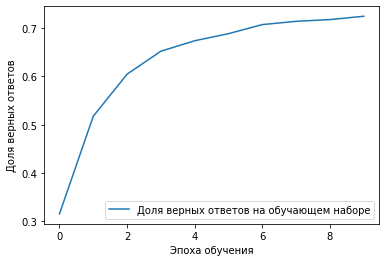

In [30]:
plt.plot(history.history['sparse_categorical_accuracy'],
         label='Доля верных ответов на обучающем наборе')
# plt.plot(history.history['val_categorical_accuracy'],
#          label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()